# Creating a custom dataset for BNHTRD

In [29]:
import os
from pathlib import Path
from contextlib import suppress
os.getcwd()

'/home/ec2-user/word_level_ocr/pritom/notebooks'

In [12]:
import glob, os
import pandas as pd

In [13]:
BNHTRD_DATASET = "/home/ec2-user/word_level_ocr/pritom/datasets/handwriting/BN-HTRd/"

In [14]:
bnhtrd_words_path = []

for file in glob.glob(BNHTRD_DATASET+"Dataset/*/Words/*/*.[jJ|pP][pP|nN][gG]"):
    bnhtrd_words_path.append(file)

In [15]:
len(bnhtrd_words_path)

108147

In [17]:
Path(bnhtrd_words_path[0]).stem

'1_1_10_1'

In [18]:
bnhtrd_word_to_path_dict = {}

for path in bnhtrd_words_path:
    bnhtrd_word_to_path_dict[Path(path).stem] = path

In [19]:
len(bnhtrd_word_to_path_dict)

108147

In [23]:
first_subdirs = os.listdir(BNHTRD_DATASET+"Dataset")

In [24]:
len(first_subdirs)

150

In [30]:
print("Folder  |  Images | Labels")

for di in first_subdirs:
    files = []
    for file in glob.glob(BNHTRD_DATASET+"/Dataset/"+di+"/Words/*/*.[jJ|pP][pP|nN][gG]"):
        files.append(file)
            
    ann_file = glob.glob(BNHTRD_DATASET+"/Dataset/"+di+"*/*.xlsx")
    try:
        df = pd.read_excel(list(ann_file)[0])
    except ValueError:
        with suppress(ValueError):
            df = pd.read_excel(list(ann_file)[0])
    
    if len(files) != len(df):
        print("Writer", di, ":", len(files), len(df))


Folder  |  Images | Labels
Writer 101 : 916 919
Writer 114 : 387 386
Writer 17 : 793 0
Writer 30 : 1357 1355
Writer 34 : 1422 746


In [10]:
total = 0
for ann_file in glob.glob(BNHTRD_DATASET+"*/*.xlsx"):
    df = pd.read_excel(ann_file)
    
    total+=len(df)
    
total

107354

In [24]:
df.head()

,Id,Word
0,109_1_1_1,করোনা
1,109_1_1_2,ভাইরাস
2,109_1_1_3,আপডেট
3,109_1_1_4,:
4,109_1_1_5,ম্যাপ


In [11]:
import os
from pathlib import Path
import glob
import pandas as pd


BNHTRD_DATASET = "/home/ec2-user/word_level_ocr/sabbir/datasets/BN-HTRd/"

total_labels = 0
total_files = 0
    
print("Folder  |  Images | Labels")

first_subdirs = os.listdir(BNHTRD_DATASET)

for di in first_subdirs:
    files = []
    for file in glob.glob(BNHTRD_DATASET+"/"+di+"/Words/*/*.[jJ|pP][pP|nN][gG]"):
        files.append(file)
        
    ann_file = glob.glob(BNHTRD_DATASET+"/"+di+"/*.xlsx")
    
    if di == "17":
        # 17.xlsx mistakenly has two sheets, and we need to specify which one to open
        df = pd.read_excel(list(ann_file)[0], sheet_name="Sheet1")
    else:
        df = pd.read_excel(list(ann_file)[0])
     
    if di=="101":
        # 101.xlsx has some trailing Nan value rows
        df = df[df['Id'].notna()]
    elif di=="60":
        df = df.rename(columns={'ID': 'Id', 'word': 'Word'})
    elif di=="30":
        # Add missing labels
        df.loc[len(df.index)] = ['30_6_2_3 (1)', 'নির্ধারকরা'] 
        df.loc[len(df.index)] = ['30_6_2_4 (1)', 'বোঝান'] 
        # Edit duplicate label
        df.loc[905] = ['30_6_6_7', 'এশিয়ায়'] 
    elif di=="114":
        # Edit duplicate label
        df.loc[905] = ['30_6_6_7', 'দেখা'] 
        
    
    total_labels += df.shape[0]
    total_files += len(files)
    
    if len(files) != df.shape[0]:
        print("Writer", di, ":", len(files), df.shape[0])

print("Total Images, Labels:", total_files, total_labels)

Folder  |  Images | Labels
Total Images, Labels: 108147 108147


In [126]:
import csv

test = 114

df_test = pd.read_excel(BNHTRD_DATASET+"/"+str(test)+"/"+str(test)+".xlsx", index=False)

label_names = set(df_test.Id)

files = []
for file in glob.glob(BNHTRD_DATASET+"/114/Words/*/*.[jJ|pP][pP|nN][gG]"):
    files.append(file)
files = set([Path(file).stem for file in files])

files.difference(label_names)

{'114_1_3_2', '114_1_8_7'}

In [79]:
df_test.columns

Index(['ID', 'word'], dtype='object')

In [36]:
107351 + 793

108144

# BNHTRD Dataset

In [8]:
import torch
from torch.utils.data import Dataset

import glob
import os
from pathlib import Path

import cv2
import numpy as np
from collections import OrderedDict
import pandas as pd

import re

BNHTRD_DATASET = "/home/ec2-user/word_level_ocr/sabbir/datasets/BN-HTRd/"

In [9]:
class BnhtrdWordDataset(Dataset):
    
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        file_paths = glob.glob(root_dir+"/*/Words/*/*.[jJ|pP][pP|nN][gG]")
        self.file_name_to_path_dict = {Path(file_path).stem:file_path for file_path in file_paths}
        
        # for file_path in file_paths:
        #     file_name = Path(file_path).stem
        #     if re.match(r"^[0-9]+_[0-9]+_[0-9]+_[0-9]+$", file_name) is None:
        #         print(file_name)
        
        self.label_dict = self._create_label_dict(root_dir)
        self.file_name_list = list(self.label_dict.keys())
        
        self.inp_h = 32
        self.inp_w = 128
        self.transform = transform
        
    def _create_label_dict(self, root_dir):
        
        annotation_files = []
        
        for subdir in os.listdir(root_dir):
            ann_file = glob.glob(root_dir+"/"+subdir+"/*.xlsx")
            
            if subdir == "17":
                # 17.xlsx mistakenly has two sheets, and we need to specify which one to open
                df = pd.read_excel(list(ann_file)[0], sheet_name="Sheet1")
            else:
                df = pd.read_excel(list(ann_file)[0])

            if subdir=="101":
                # 101.xlsx has some trailing Nan value rows
                df = df[df['Id'].notna()]
            elif subdir=="60":
                df = df.rename(columns={'ID': 'Id', 'word': 'Word'})
            
            annotation_files.append(df)
        
        merged_dataframe = pd.concat(annotation_files)
        # Remove duplicate entries
        merged_dataframe = merged_dataframe.drop_duplicates(subset='Id', keep="first")
        
        merged_dict = dict(zip(merged_dataframe.Id, merged_dataframe.Word))
        
        # Some file names do not match with their equivalent in the excel files
        # We ignore those files
        cleaned_dict = {k:str(v) for (k, v) in merged_dict.items() if \
                        re.match(r"^[0-9]+_[0-9]+_[0-9]+_[0-9]+$", k) is not None \
                       and k in self.file_name_to_path_dict.keys()}
        
        return cleaned_dict
            
        
    def __len__(self):
        return len(self.label_dict)
        
    def __getitem__(self, idx):
        file_name = self.file_name_list[idx]
        file_path = self.file_name_to_path_dict[file_name]
        
        label = self.label_dict[file_name]
        
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        img_h, img_w = image.shape
        image = cv2.resize(image, (0,0), fx=self.inp_w / img_w, fy=self.inp_h / img_h, interpolation=cv2.INTER_CUBIC)
        image = np.reshape(image, (self.inp_h, self.inp_w, 1))
        
        if self.transform is not None:
            image = self.transform(image = image)["image"]
            return image, file_name, idx
        else:
            image = image.transpose(2, 0, 1)
            return image, label, idx
        

In [10]:
bnhtrd = BnhtrdWordDataset(BNHTRD_DATASET)

In [11]:
file_path = bnhtrd.file_name_to_path_dict
len(file_path)

108147

In [12]:
labels = bnhtrd.label_dict
len(labels)

107090

In [50]:
v1="সংসদ9"
lol = "ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz0123456789\u200d\u200c\n ©"
flag=True
for i in v1:
    if i in lol:
        flag=False
        break
if flag:
    print(v1)

In [14]:
from shutil import copyfile
from tqdm import tqdm

# not excluding space as some xlsx label files has space in them. space is removed afterwards using
# strip. but this also makes empty labels which are then removed in mod_train and mod_val
EXCLUDE_CLASSES = "ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz0123456789\u200d\u200c\n©"
#v1=সংসদ v2=path
DESTINATION_PATH = '/home/ec2-user/word_level_ocr/rakib/datasets/bnhtrd/'
if input("Start copying?") == "YES":
     with open(DESTINATION_PATH + "all_labels.txt", "w", encoding="utf8") as f:
            id=0
            for k1,v1 in tqdm(labels.items()):
                take_word=True
                for k2,v2 in file_path.items():
                    if k1==k2:
                        for i in v1:
                            if i in EXCLUDE_CLASSES:
                                take_word=False
                                break
                        if take_word:
                            src=v2
                            des_name = "{}.jpg".format(id)
                            destn = DESTINATION_PATH + "all/" + des_name
                            f.write("{} {}\n".format(des_name, v1.strip()))
                            copyfile(src, destn)
                            id=id+1
                            break
                        else:
                            break
            print(f"Next train filename should start with id: {id}.jpg")
else:
    print("Not copied")            

Start copying? YES


100%|██████████| 107090/107090 [08:10<00:00, 218.12it/s]

Next train filename should start with id: 104504.jpg


In [3]:
from shutil import copyfile
import random
import glob
from tqdm import tqdm 

In [17]:
# DESTINATION_PATH = '/home/ec2-user/word_level_ocr/rakib/datasets/bnhtrd/'
# with open(DESTINATION_PATH + "all_labels.txt", "r") as f:
#     all_labels = f.readlines()

# all_labels = [x.strip() for x in all_labels]
# random.shuffle(all_labels)
# train = all_labels[:round(0.8*len(all_labels))]
# val = all_labels[-round(0.2*len(all_labels)):]
# len(train), len(val), len(all_labels)

(83603, 20901, 104504)

In [66]:
train[38194]

'101020.jpg প্রবৃদ্ধির'

In [67]:
mod_train = []
i=0
for line in train:
    n = line.split()
    if not (len(n)<2 or len(n)>2):
        mod_train.append(line) 
len(mod_train)

83571

In [69]:
mod_val = []
i=0
for line in val:
    n = line.split()
    if not (len(n)<2 or len(n)>2):
        mod_val.append(line) 
len(mod_val)

20898

In [20]:
# DESTINATION_PATH = '/home/ec2-user/word_level_ocr/rakib/datasets/bnhtrd_train_val/'
# BNHTRD_PATH = '/home/ec2-user/word_level_ocr/rakib/datasets/bnhtrd/'
# if input("Start copying?") == "YES":
#     with open(DESTINATION_PATH + "train_labels.txt", "w", encoding="utf8") as f:
#         id=0
#         for line in tqdm(mod_train):
#             src_name = line.split()[0]
#             word = line.split()[1]
#             src = BNHTRD_PATH  + "all/" + src_name
#             des_name = "{}.jpg".format(id)
#             destn = DESTINATION_PATH + "train/" + des_name
#             f.write("{} {}\n".format(des_name, word))
#             copyfile(src,destn)
#             id=id+1
#         print(f"Next train filename should start with id: {id}.jpg")
# else:
#     print("Not copied")

Start copying? YES


100%|██████████| 83571/83571 [00:19<00:00, 4202.85it/s]

Next train filename should start with id: 83571.jpg


In [21]:
# DESTINATION_PATH = '/home/ec2-user/word_level_ocr/rakib/datasets/bnhtrd_train_val/'
# BNHTRD_PATH = '/home/ec2-user/word_level_ocr/rakib/datasets/bnhtrd/'
# if input("Start copying?") == "YES":
#     with open(DESTINATION_PATH + "valid_labels.txt", "w", encoding="utf8") as f:
#         id=0
#         for line in tqdm(mod_val):
#             src_name = line.split()[0]
#             word = line.split()[1]
#             src = BNHTRD_PATH  + "all/" + src_name
#             des_name = "{}.jpg".format(id)
#             destn = DESTINATION_PATH + "valid/" + des_name
#             f.write("{} {}\n".format(des_name, word))
#             copyfile(src,destn)
#             id=id+1
#         print(f"Next train filename should start with id: {id}.jpg")
# else:
#     print("Not copied")

Start copying? YES


100%|██████████| 20898/20898 [00:01<00:00, 18585.50it/s]

Next train filename should start with id: 20898.jpg


In [41]:
DESTINATION_PATH = '/home/ec2-user/word_level_ocr/rakib/datasets/bnhtrd_train_val/'
with open(DESTINATION_PATH + "train_labels.txt", "r") as f:
    train_labels = f.readlines()
train_labels = [x.strip() for x in train_labels]

DESTINATION_PATH = '/home/ec2-user/word_level_ocr/rakib/datasets/bnhtrd_train_val/'
with open(DESTINATION_PATH + "valid_labels.txt", "r") as f:
    valid_labels = f.readlines()
valid_labels = [x.strip() for x in valid_labels]

len(train_labels), len(valid_labels)

(83571, 20898)

In [30]:
DESTINATION_PATH = '/home/ec2-user/word_level_ocr/rakib/datasets/bnhtrd_all/'
BNHTRD_PATH = '/home/ec2-user/word_level_ocr/rakib/datasets/bnhtrd_train_val/'
if input("Start copying?") == "YES":
    with open(DESTINATION_PATH + "all_labels.txt", "w", encoding="utf8") as f:
        id=0
        for line in tqdm(train_labels):
            src_name = line.split()[0]
            word = line.split()[1]
            src = BNHTRD_PATH  + "train/" + src_name
            des_name = "{}.jpg".format(id)
            destn = DESTINATION_PATH + "all/" + des_name
            f.write("{} {}\n".format(des_name, word))
            copyfile(src,destn)
            id=id+1
        print(f"Next train filename should start with id: {id}.jpg")
else:
    print("Not copied")

Start copying? YES


100%|██████████| 83571/83571 [00:04<00:00, 18465.40it/s]

Next train filename should start with id: 83571.jpg


In [31]:
DESTINATION_PATH = '/home/ec2-user/word_level_ocr/rakib/datasets/bnhtrd_all/'
BNHTRD_PATH = '/home/ec2-user/word_level_ocr/rakib/datasets/bnhtrd_train_val/'
if input("Start copying?") == "YES":
    with open(DESTINATION_PATH + "all_labels.txt", "a", encoding="utf8") as f:
        id=83571
        for line in tqdm(valid_labels):
            src_name = line.split()[0]
            word = line.split()[1]
            src = BNHTRD_PATH  + "valid/" + src_name
            des_name = "{}.jpg".format(id)
            destn = DESTINATION_PATH + "all/" + des_name
            f.write("{} {}\n".format(des_name, word))
            copyfile(src,destn)
            id=id+1
        print(f"Next train filename should start with id: {id}.jpg")
else:
    print("Not copied")

Start copying? YES


100%|██████████| 20898/20898 [00:01<00:00, 18342.14it/s]

Next train filename should start with id: 104469.jpg


In [36]:
DESTINATION_PATH = '/home/ec2-user/word_level_ocr/rakib/datasets/bnhtrd_all/'
with open(DESTINATION_PATH + "all_labels.txt", "r") as f:
    all_labels = f.readlines()
all_labels = [x.strip() for x in all_labels]
len(all_labels)

104469

In [72]:
# DESTINATION_PATH = '/home/ec2-user/word_level_ocr/rakib/datasets/bnhtrd_train_val/'
# a = glob.glob(DESTINATION_PATH + "train/*.jpg")
# # import os
# # a = sorted(os.listdir(DESTINATION_PATH + "train/"))
# # for i in a:
# #     print(i)
# #     print(int(i.split('.')[0]))
# # # b = sorted(a, key=lambda x: int(x.split('.')[0]))
# len(a)

83571

In [102]:
bnhtrd[0][0]

array([[[224, 224, 224, ..., 223, 225, 225],
        [224, 224, 224, ..., 223, 224, 224],
        [224, 224, 224, ..., 224, 224, 224],
        ...,
        [223, 223, 223, ..., 224, 224, 224],
        [224, 224, 224, ..., 222, 224, 225],
        [224, 224, 224, ..., 225, 224, 222]]], dtype=uint8)

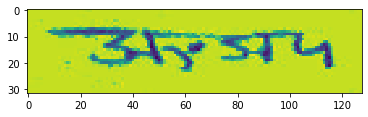

In [103]:
from matplotlib import pyplot as plt
plt.imshow(bnhtrd[0][0][0], interpolation='nearest')
plt.show()

In [104]:
errors=0
for i in range(len(bnhtrd)):
    errors+=1
    data=bnhtrd[i]

errors

107090

## Investigating character labels in the usable images

In [105]:
def normalize_word(word):

    if 'ো' in word: word = word.replace('ো', 'ো')
    
    if 'ৗ' in word:    
        if 'ৌ' in word: word = word.replace('ৌ', 'ৌ') 
        else: word = word.replace('ৗ', 'ী') # 'ৗ' without 'ে' is replaced by 'ী'
    
    if '়' in word:
        if 'ব়' in word: word = word.replace('ব়', 'র')
        if 'য়' in word: word = word.replace('য়', 'য়')
        if 'ড়' in word: word = word.replace('ড়', 'ড়')
        if 'ঢ়' in word: word = word.replace('ঢ়', 'ঢ়')
        if '়' in word: word = word.replace('়', '') # discard any other '়' without 'ব'/'য'/'ড'/'ঢ'
        
    # visually similar '৷' (Bengali Currency Numerator Four) is replaced by '।' (Devanagari Danda)
    if '৷' in word: word = word.replace('৷', '।')
    
    return word

In [106]:
# Keep Consonant Clusters Intact
def extract_graphemes(word):
    
    forms_cluster = {'ক': ['ক', 'ট', 'ত', 'ন', 'ব', 'ম', 'র', 'ল', 'ষ', 'স'],
                     'গ': ['গ', 'ধ', 'ন', 'ব', 'ম', 'ল'],
                     'ঘ': ['ন'],
                     'ঙ': ['ক', 'খ', 'গ', 'ঘ', 'ম'],
                     'চ': ['চ', 'ছ', 'ঞ'],
                     'জ': ['জ', 'ঝ', 'ঞ', 'ব'],
                     'ঞ': ['চ', 'ছ', 'জ', 'ঝ'],
                     'ট': ['ট', 'ব'],
                     'ড': ['ড'],
                     'ণ': ['ট', 'ঠ', 'ড', 'ঢ', 'ণ', 'ব', 'ম'],
                     'ত': ['ত', 'থ', 'ন', 'ব', 'ম', 'র'],
                     'থ': ['ব'],
                     'দ': ['গ', 'ঘ', 'দ', 'ধ', 'ব', 'ভ', 'ম'],
                     'ধ': ['ন', 'ব'],
                     'ন': ['জ', 'ট', 'ঠ', 'ড', 'ত', 'থ', 'দ', 'ধ', 'ন', 'ব', 'ম', 'স'],
                     'প': ['ট', 'ত', 'ন', 'প', 'ল', 'স'],
                     'ফ': ['ট', 'ল'],
                     'ব': ['জ', 'দ', 'ধ', 'ব', 'ভ', 'ল'],
                     'ভ': ['র'],
                     'ম': ['ন', 'প', 'ফ', 'ব', 'ভ', 'ম', 'ল'],
                     'ল': ['ক', 'গ', 'ট', 'ড', 'প', 'ফ', 'ব', 'ম', 'ল', 'স'],
                     'শ': ['চ', 'ছ', 'ত', 'ন', 'ব', 'ম', 'ল'],
                     'ষ': ['ক', 'ট', 'ঠ', 'ণ', 'প', 'ফ', 'ব', 'ম'],
                     'স': ['ক', 'খ', 'ট', 'ত', 'থ', 'ন', 'প', 'ফ', 'ব', 'ম', 'ল'],
                     'হ': ['ণ', 'ন', 'ব', 'ম', 'ল'],
                     'ড়': ['গ']}
    
    forms_tripple_cluster = {'ক্ষ': ['ণ', 'ম'], 'ঙ্ক': ['ষ'], 'চ্ছ': ['ব'], 'জ্জ': ['ব'],
                             'ত্ত': ['ব'], 'দ্দ': ['ব'], 'দ্ধ': ['ব'], 'দ্ভ': ['র'],
                             'ন্ত': ['ব'], 'ন্দ': ['ব'], 'ম্প': ['ল'], 'ম্ভ': ['র'],
                             'ষ্ক': ['র'], 'স্ক': ['র'], 'স্ত': ['ব', 'র'], 'স্প': ['ল']}
    
    chars = []
    i = 0
    adjust = 0
    
    while(i < len(word)):
        if i+1 < len(word) and word[i+1] == '্':
            if word[i] == 'র':
                chars.append('র্')
                adjust = 0
                i+=2
            elif i+2 < len(word) and word[i+2] == 'য':
                chars.append(word[i-adjust:i+1])
                chars.append('্য')
                adjust = 0
                i+=3
            elif i+2 < len(word) and word[i+2] == 'র':
                # Treat '্র' as a seperate grapheme
                chars.append(word[i-adjust:i+1])
                chars.append('্র')
                # Keep '্র' icluded in the cluster
                # chars.append(word[i-adjust:i+3])
                if i+3 < len(word) and word[i+3] == '্' and i+4 < len(word) and word[i+4] == 'য':    
                    chars.append('্য')
                    i+=5
                else:
                    i+=3
                adjust = 0
            elif i+2 < len(word) and adjust!=0 and word[i-adjust:i+1] in forms_tripple_cluster \
                and word[i+2] in forms_tripple_cluster[word[i-adjust:i+1]]:
                if i+3 < len(word) and word[i+3] == '্':
                    adjust += 2
                    i+=2
                else:
                    chars.append(word[i-adjust:i+3])
                    adjust = 0
                    i+=3
            elif i+2 < len(word) and adjust==0 and word[i] in forms_cluster and word[i+2] in forms_cluster[word[i]]:
                if i+3 < len(word) and word[i+3] == '্':
                    adjust += 2
                    i+=2
                else:
                    chars.append(word[i-adjust:i+3])
                    adjust = 0
                    i+=3
            else:
                chars.append(word[i-adjust:i+1])
                chars.append('্')
                adjust = 0
                i+=2

        else:
            chars.append(word[i:i+1])
            i+=1

    
    #print(word)
    #print(chars)

    return chars

In [107]:
bnhtrd = BnhtrdWordDataset(BNHTRD_DATASET)
label_dict = bnhtrd.label_dict

In [108]:
grapheme_set = set()

for file_name, label in label_dict.items():
    # print(label, type(label))
    graphemes_in_label = extract_graphemes(normalize_word(label))
    grapheme_set = grapheme_set.union(graphemes_in_label)
    
print(grapheme_set)
print(len(grapheme_set))

{'ণ্ঠ', 'ূ', 'ক্ত', 'আ', 'ব্ল', 'গ্ধ', 'ত্থ', 'া', 'প্ল', 'দ্ম', 'স্ল', 'f', 'ৈ', 'ম্ন', 'ক্ক', 'ণ্ট', 'ঋ', 'গ', 'ত', '—', '•', 'ঙ্খ', 'b', 'ড', 'জ্ব', 'ক', 'k', 'ঙ্ক্ষ', '্', '7', 'ক্ষ', '·', 'ত্ম', 'J', 'হ্ণ', 'গ্ল', 'K', 'A', 'ষ্ক', 'g', 'F', 'ত্ত', 'ধ', '[', 'প্প', 'ড়', 'ষ্ট', 'O', 'ঞ্জ', 'ত্ন', 'ম্ল', 'M', '“', '8', 'ন', '২', 'ক্ন', 'ঃ', 'শ্ব', 'শ্চ', 'ঢ', 'স্ব', 'U', '৮', 'ল্ল', '\u200c', 'ড্ড', 'D', 'স্ন', 'হ্ব', 'S', 'ষ্ণ', 'ম্ম', '&', 'চ', 'ল্প', 'ধ্ব', 'd', 'ৌ', 'স্থ', '©', '\u200d', 'ল্ফ', 't', 'ন্ড', 'w', 'উ', 'ঢ়', 'ক্ল', '@', 'হ্ন', 'ন্ন', 'স্ম', 'ট্ট', 'স্ত', 'ল্ড', 'ু', 'ব্ধ', '|', 'ন্স', 'প', 'ষ্প', 'R', 'P', 'ভ', '–', '+', ']', 'ল্ট', 'ণ', 'ছ', 'ক্স', 'ে', 'ন্ব', 'ঈ', 'ঊ', 'ত্ব', '1', 'জ', 'ী', 'I', 'খ', '5', 'ণ্ড', 'ফ্ল', 'ং', 'ঘ্ন', 'প্ত', ',', 'দ্ভ', ':', 'স্প', 'H', 'z', 'ও', 'N', 'ৎ', 'C', 'ঙ্গ', 'm', '3', 'ম্ভ', 'ষ্ম', 'হ্ম', '”', 'ঠ', 'স্ট', 'G', 'ণ্ণ', 'অ', 'ন্ম', 'B', '?', 'ঘ', 'ন্দ্ব', 'জ্জ', 'ঙ', 'ব', '৭', 'ম্ব', '/', 'ি', 'ো', 'শ্ল', 'প্ন', 'শ্ম', 'Q', '*',

In [109]:
graphemes_count_dict = {k:0 for k in grapheme_set}

for file_name, label in label_dict.items():
    # print(label, type(label))
    graphemes_in_label = extract_graphemes(normalize_word(label))
    for grapheme in graphemes_in_label:
        graphemes_count_dict[grapheme] += 1
        
graphemes_count_dict

print(sorted([(k,v) for k,v in graphemes_count_dict.items()], key=lambda x: x[1], reverse=True))

[('া', 50414), (' ', 48871), ('ে', 44887), ('র', 32625), ('ি', 28282), ('ন', 22238), ('ক', 20532), ('ব', 18634), ('ত', 13679), ('স', 13004), ('ল', 12866), ('ম', 11367), ('য়', 9981), ('প', 9802), ('দ', 8488), ('ু', 8141), ('ো', 6816), ('হ', 6790), ('।', 6060), ('ই', 6040), ('শ', 5909), ('ট', 5807), ('্র', 5634), ('জ', 5621), ('্য', 5513), ('এ', 5263), ('ছ', 5195), ('আ', 4904), ('গ', 4495), ('ী', 4355), ('ভ', 4185), ('র্', 3999), ('য', 3630), ('ং', 3302), ('চ', 3286), (',', 3276), ('খ', 3125), ('ও', 2975), ('থ', 2821), ('অ', 2628), ('ধ', 2331), ('উ', 1875), ('ণ', 1871), ('ড়', 1661), ('ফ', 1514), ('ষ', 1466), ('ন্ত', 1419), ('ক্ষ', 1390), ('-', 1242), ('ড', 1204), ('1', 977), ('0', 932), ('"', 912), ('স্থ', 819), ('ৃ', 803), ('2', 799), ('ূ', 745), ('ঠ', 689), ('শ্ব', 669), ('ঁ', 594), ('ক্ত', 592), ('ন্দ', 576), ('চ্ছ', 563), ('ঘ', 554), ("'", 549), ('ৈ', 498), ('ষ্ট', 490), ('স্ট', 488), ('ৎ', 486), ('স্ত', 480), ('ঙ্গ', 457), (':', 452), ('স্ব', 437), ('দ্ধ', 418), ('9', 418), ('ম্প', 

In [114]:
EXCLUDE_CLASSES = "ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz0123456789\u200d\u200c\n ©"

after_exclusion = grapheme_set.difference(EXCLUDE_CLASSES)
print(after_exclusion)
print(len(after_exclusion))

{'ণ্ঠ', 'ূ', 'ক্ত', 'আ', 'ব্ল', 'গ্ধ', 'ত্থ', 'া', 'প্ল', 'দ্ম', 'স্ল', 'ৈ', 'ম্ন', 'ক্ক', 'ণ্ট', 'ঋ', 'গ', 'ত', '—', '•', 'ঙ্খ', 'ড', 'জ্ব', 'ক', 'ঙ্ক্ষ', '্', 'ক্ষ', '·', 'ত্ম', 'হ্ণ', 'গ্ল', 'ষ্ক', 'ত্ত', 'ধ', '[', 'প্প', 'ড়', 'ষ্ট', 'ঞ্জ', 'ত্ন', 'ম্ল', '“', 'ন', '২', 'ক্ন', 'ঃ', 'শ্ব', 'শ্চ', 'ঢ', 'স্ব', '৮', 'ল্ল', 'ড্ড', 'স্ন', 'হ্ব', 'ষ্ণ', 'ম্ম', '&', 'চ', 'ল্প', 'ধ্ব', 'ৌ', 'স্থ', '\u200d', 'ল্ফ', 'ন্ড', 'উ', 'ঢ়', 'ক্ল', '@', 'হ্ন', 'ন্ন', 'স্ম', 'ট্ট', 'স্ত', 'ল্ড', 'ু', 'ব্ধ', '|', 'ন্স', 'প', 'ষ্প', 'ভ', '–', '+', ']', 'ল্ট', 'ণ', 'ছ', 'ক্স', 'ে', 'ন্ব', 'ঈ', 'ঊ', 'ত্ব', 'জ', 'ী', 'খ', 'ণ্ড', 'ফ্ল', 'ং', 'ঘ্ন', 'প্ত', ',', 'দ্ভ', ':', 'স্প', 'ও', 'ৎ', 'ঙ্গ', 'ম্ভ', 'ষ্ম', 'হ্ম', '”', 'ঠ', 'স্ট', 'ণ্ণ', 'অ', 'ন্ম', '?', 'ঘ', 'ন্দ্ব', 'জ্জ', 'ঙ', 'ব', '৭', 'ম্ব', '/', 'ি', 'ো', 'শ্ল', 'প্ন', 'শ্ম', '*', 'ষ্ঠ', '"', '৪', 'ক্ষ্ম', 'দ', '১', 'ব্দ', 'ঔ', 'ন্ত', 'র', 'ঝ', 'স্ক', 'জ্ঞ', 'ঙ্ক', 'ম্ফ', "'", 'স্ফ', 'শ', 'ৃ', '%', 'চ্চ', 'ট', 'দ্ধ', '’', 'ন্ট', 'গ্ম', '।', 'ল', 'ন্থ',

In [86]:
for file_name, label in label_dict.items():
    graphemes_in_label = extract_graphemes(normalize_word(label))
    if "\n" in graphemes_in_label:
        print(graphemes_in_label)
        break

['অ', 'ব', 'স্থ', 'া', ' ', '\n']


In [113]:
"০"=="O"

False